# IMPTOX - 
# Labelbox model assisted labeling

This tutorial implements Labelbox model assisted labeling (MAL) system (https://labelbox.com/docs/automation/model-assisted-labeling) for object detection (bbox) and image segmentation (masks) with Facebook Detectron2 framework. MAL integrates Labelbox labeling workflow directly with the user AI model. MAL is a superior technique to quickly improve AI model performance. 

#### ![MAL](https://files.helpdocs.io/3fu9z5w5lj/articles/6o94494p7f/1587521917175/model-assisted-labeli.png)

### What you need and know before getting started?
- Labelbox API key
- A partially labeled project in Labelbox. (bounding box or segmentation)
- (optional) GCS credentials to upload segmentation masks to a bucket.
- For ideal performance, replace Facebook Detectron2 with your own AI model.
---

### Workflow
**Data preparation (egress)**
- Generate Labelbox project export and download labels (Labelbox)
- Access ontology (Labelbox)
- Convert labels into Facebook Detectron2 custom format (Labelbox)

**Train your AI model**
- Visualize Detectron2 training data (Labelbox)
- Configure Detectron2 Training configuration (Labelbox)
- Run Detectron2 training (Labelbox)
- Evaluate Detectron2 performance (Labelbox)

**Data preparation (inference)**
- Compute unlabeled datarows within a project for inferencing (Labelbox)

**Model inferencing on unlabeled data**
- Run Detectron2 inference on queued datarows (Detectron)

**Data preparation (ingress)**
- Convert Detectron2 inference results to Labelbox annotation import format (Labelbox)
- Initiate bulk import request to import pre-labels (Labelbox)


---

# About
[Labelbox](https://labelbox.com/) is a training data platform to easily create training data and improve model performance. 

#### ![Labelbox workmark](https://i.imgur.com/ufIZpXq.png)

# Install dependencies 

In [1]:
# !pip3 install --upgrade pip setuptools
#!pip3 install -U torch torchvision -f https://download.pytorch.org/whl/cu101/torch_stable.html 
#!pip3 install cython pyyaml==5.1
#!pip3 install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

# install detectron2:
#!pip3 install detectron2==0.1.3 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html
#!pip3 install opencv-python
#!pip3 install labelbox
#!pip3 install simplejson
#!pip3 install progressbar
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
#!pip3 install google-cloud-storage

1.11.0+cu102 True
gcc (Ubuntu 9.4.0-1ubuntu1~20.04.1) 9.4.0
Copyright (C) 2019 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



/home/thibault.schowing/miniconda3/envs/labelbox/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

# Import libraries

In [3]:

##General utilities
import datetime as dt
import os
import sys
import random
import time
from itertools import cycle
from uuid import uuid4
import requests
from pprint import pprint
from multiprocessing.pool import ThreadPool
import os, os.path
import numpy as np
import cv2
from skimage import io
import simplejson as json
import random
from datetime import datetime
import time
import shutil
from matplotlib import pyplot as plt
from pycocotools import mask
import progressbar
from PIL import Image
from google.cloud import storage
#from google.colab.patches import cv2_imshow

##Labelbox utilities
import labelbox as lb
from labelbox import Project, Dataset
from labelbox.schema.bulk_import_request import BulkImportRequest
from labelbox.schema.enums import BulkImportRequestState

##Facebook Detectron2 utilities
from detectron2.structures import BoxMode
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2 import model_zoo
from detectron2.evaluation import COCOEvaluator
from detectron2.engine import DefaultPredictor
from detectron2.utils.visualizer import Visualizer
from detectron2.utils.visualizer import ColorMode

# Configure parameters

In [4]:
# Upload GCS configuration json
#from google.colab import files
#uploaded = files.upload()


In [5]:
LB_API_KEY = ""
ENDPOINT = "https://api.labelbox.com/graphql"
GCS_KEY = ""

### Uncomment the object detection example to use with object detection projects

# # Object detection example
PROJECT_ID='cl1xko1at42480zai2aheh2ip' #labelbox project id
DATASETS=['cl27701bl2b9a0z53gha4h2jv'] #labelbox dataset ids attached to the project

#MODE = 'object-detection' 
#DATA_LOCATION = 'obj-data/'



#Segmentation example 
# PROJECT_ID='ckc10shc3d9230988ejrdwraj' #labelbox project id
DATA_LOCATION = 'seg-data/'
MODE = 'segmentation-rle'

## Universal configuration
DOWNLOAD_IMAGES = True # Download data from labelbox. Set false for re-runs when data already exists locally
VALIDATION_RATIO = 0.2 # Validation data / training data ratio
NUM_CPU_THREADS = 8 # for multiprocess downloads
NUM_SAMPLE_LABELS = 0 # Use 0 to use all of the labeled training data from project. Otherwise specify number of labeled images to use. Use smaller number for faster iteration. 
PRELABELING_THRESHOLD = 0.2 # minimum model inference confidence threshold to be uploaded to labelbox
HEADLESS_MODE = False # Set True to skip previewing data or model results

DETECTRON_DATASET_TRAINING_NAME = 'prelabeling-train'
DETECTRON_DATASET_VALIDATION_NAME = 'prelabeling-val'

# Functions

In [6]:
## get project ontology from labelbox
def get_ontology(project_id):
    response = client.execute(
                """
                query getOntology (
                    $project_id : ID!){ 
                    project (where: { id: $project_id }) { 
                        ontology { 
                            normalized 
                        } 
                    }
                }
                """,
                {"project_id": project_id})
            
    ontology = response['project']['ontology']['normalized']['tools']

    ##Return list of tools and embed category id to be used to map classname during training and inference
    mapped_ontology = []
    thing_classes = []
    
    i=0
    for item in ontology:
#         if item['tool']=='superpixel' or item['tool']=='rectangle':
        item.update({'category': i})
        mapped_ontology.append(item)
        thing_classes.append(item['name'])
        i=i+1         

    return mapped_ontology, thing_classes

## Creates a new export request to get all labels from labelbox. 
def get_labels(project_id):
    should_poll = 1
    while(should_poll == 1):
        response = client.execute(
                    """
                    mutation export(
                    $project_id : ID!    
                    )
                    { 
                        exportLabels(data:{ projectId: $project_id }){ 
                            downloadUrl 
                            createdAt 
                            shouldPoll 
                        }
                    }
                    """,
                    {"project_id": project_id})
        
        if response['exportLabels']['shouldPoll'] == False:
            should_poll = 0
            url = response['exportLabels']['downloadUrl']
            headers = {"User-Agent":"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/83.0.4103.97 Safari/537.36"}

            r = requests.get(url, headers=headers)
            
            print('Export generated')
            ## writing export to disc for easier debugging
            open('export.json', 'wb').write(r.content)
            return r.content
        else:
            print('Waiting for export generation. Will check back in 10 seconds.')    
            time.sleep(10)

    return response

## Get all previous predictions import (bulk import request). 
def get_current_import_requests():
    response = client.execute(
                    """
                    query get_all_import_requests(
                        $project_id : ID! 
                    ) {
                      bulkImportRequests(where: {projectId: $project_id}) {
                        id
                        name
                      }
                    }
                    """,
                    {"project_id": PROJECT_ID})
    
    return response['bulkImportRequests']

## Delete all current predictions in a project and dataset. We want to delete them and start fresh with predictions from the latest model iteration
def delete_import_request(import_request_id):
    response = client.execute(
                    """
                        mutation delete_import_request(
                            $import_request_id : ID! 
                        ){
                          deleteBulkImportRequest(where: {id: $import_request_id}) {
                            id
                            name
                          }
                        }
                    """,
                    {"import_request_id": import_request_id})
    
    return response

## function to return the difference between two lists. This is used to compute the queued datarows to be used for inference. 
def diff_lists(li1, li2): 
    li_dif = [i for i in li1 + li2 if i not in li1 or i not in li2] 
    return li_dif 

## Generic data download function
def download_files(filemap):
    path, uri = filemap    
    ## Download data
    if not os.path.exists(path):
        r = requests.get(uri, stream=True)
        if r.status_code == 200:
            with open(path, 'wb') as f:
                for chunk in r:
                    f.write(chunk)
    return path

## Converts binary image mask into COCO RLE format
def rle_encode(mask_image):
    size = list(mask_image.shape)
    pixels = mask_image.flatten()
    
    # We avoid issues with '1' at the start or end (at the corners of 
    # the original image) by setting those pixels to '0' explicitly.
    # We do not expect these to be non-zero for an accurate mask, 
    # so this should not harm the score.
    pixels[0] = 0
    pixels[-1] = 0
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 2
    runs[1::2] = runs[1::2] - runs[:-1:2]
    
    rle = {'counts': runs.tolist(), 'size': size}
    return rle


def load_set(dir):
    with open(dir+"dataset.json") as json_file:
        dataset_dicts = json.loads(json_file)
    return dataset_dicts

def cv2_imshow(a, **kwargs):
#     a = a.clip(0, 255).astype('uint8')
    # cv2 stores colors as BGR; convert to RGB
    if a.ndim == 3:
        if a.shape[2] == 4:
            a = cv2.cvtColor(a, cv2.COLOR_BGRA2RGBA)
        else:
            a = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)

    return plt.imshow(a, **kwargs)

def upload_to_gcs(file_name):
    bucket = storage_client.get_bucket("storage-test-1-imptox")
    blob = bucket.blob("{}.png".format(str(uuid4())))
    blob.upload_from_filename(file_name)
    return blob.generate_signed_url(dt.timedelta(weeks=10))

def mask_to_cloud(img, mask_array, filename):
    num_instances = mask_array.shape[0]
    mask_array = np.moveaxis(mask_array, 0, -1)
    mask_array_instance = []
    output = np.zeros_like(img)
    for i in range(num_instances):
        mask_array_instance.append(mask_array[:, :, i:(i+1)])
        output = np.where(mask_array_instance[i] == True, 255, output)
    im = Image.fromarray(output)
    im.save(DATA_LOCATION+'tmp/'+filename+'.png')
    
    cloud_mask = upload_to_gcs(DATA_LOCATION+'tmp/'+filename+'.png')
#     plt.imshow(im)
    return cloud_mask

## Convert and load labelbox labels into Detectron2 format
def load_detectron2_dataset(labels, ontology, thing_classes, dir):
    dataset_dicts = []
    i = 0
    total = len(labels)

    print("Num labels processing: " + str(total))
    time.sleep(1)
    bar = progressbar.ProgressBar(maxval=total, \
        widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
    bar.start()
    
    for label in labels:
        
        try:
            record = {}
            filename = os.path.join(dir, label['External ID'])
            
            ##scikit needed to raise exception if unable to read the image
            _ = io.imread(filename)
            
            height, width = cv2.imread(filename).shape[:2]

            record["file_name"] = filename
            record["height"] = height
            record["width"] = width
            record["image_id"] = label['ID']

            objs = []

            for instance in label['Label']['objects']:
                category_id = thing_classes.index(instance['title'])
#                 print(category_id)
                if MODE == 'object-detection':
                    obj = {
                            "bbox": [instance['bbox']['left'], instance['bbox']['top'], instance['bbox']['width'], instance['bbox']['height']],
                            "bbox_mode": BoxMode.XYWH_ABS,
                            "segmentation": [],
                            "category_id": category_id,
                        }
                    objs.append(obj)

                if MODE == 'segmentation-rle':
                    path = DATA_LOCATION+masks+'/'+label['External ID']
                    mask_URI = instance['instanceURI']
                    downloaded_path = download_files((path, mask_URI))
                    im = cv2.imread(downloaded_path,0)

                    binary = np.array(im)

                    rle = mask.encode(np.asfortranarray(binary))
                    ground_truth_bounding_box = mask.toBbox(rle)

                    obj = {
                            "bbox": ground_truth_bounding_box.tolist(),
                            "bbox_mode": BoxMode.XYWH_ABS,
                            "segmentation": rle,
                            "category_id": category_id,
                            "iscrowd": 0
                        }
                    objs.append(obj)

            record["annotations"] = objs
            dataset_dicts.append(record)
            
            bar.update(i+1)
            i=i+1
        except Exception as e:
            print('Exception: ', e)

    bar.finish()
            
    ## Write detectron2 dataset file to disk for easier debugging
    f = open(dir+"dataset_dict.json","w")
    f.write(json.dumps(dataset_dicts))
    f.close()
    
    return dataset_dicts


    

class CocoTrainer(DefaultTrainer):

    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):

        if output_folder is None:
            os.makedirs("coco_eval", exist_ok=True)
            output_folder = "coco_eval"

        return COCOEvaluator(dataset_name, cfg, False, output_folder)



In [7]:
!ls


 coco_eval
 coco_instances_results.json
 export.json
'IMPTOX - model-assisted-labeling.ipynb'
 IMPTOX_server_test.ipynb
 instances_predictions.pth
 key_rw.json
 output
 prelabeling-val_coco_format.json
 prelabeling-val_coco_format.json.lock
 seg-data


# Main

In [21]:
if os.path.exists('coco_eval'):
    shutil.rmtree('coco_eval')
    
client = lb.Client(LB_API_KEY, "https://api.labelbox.com/graphql")
storage_client = storage.Client.from_service_account_json(GCS_KEY)

## Get labelbox project
project = client.get_project(PROJECT_ID)

##Get ontology
ontology, thing_classes = get_ontology(PROJECT_ID)
print('Available classes: ', thing_classes)

##Get labels
labels = json.loads(get_labels(PROJECT_ID))

## Labels format
print(labels[1:5])

Available classes:  ['particle', 'particle_seg', 'particle']
Export generated
[{'ID': 'cl27728182axw0z5yfwsfhii9', 'DataRow ID': 'cl27709mc000v0zwd69jog2tm', 'Labeled Data': 'https://storage.labelbox.com/ckx5rns9a7ukj0zawbh2645im%2Fc634e4eb-ac68-ca36-54b3-e527a1644151-220420_752x480-Sample51.jpg?Expires=1654675466152&KeyName=labelbox-assets-key-3&Signature=wP8fjiWTwf8yvW6j5CZdL-zkrlU', 'Label': {'objects': [{'featureId': 'cl27756sn0007396czocb7jgv', 'schemaId': 'cl2771vun26q90z3j407dgam4', 'color': '#1CE6FF', 'title': 'particle', 'value': 'particle', 'polygon': [{'x': 89.104, 'y': 81.97}, {'x': 109.596, 'y': 140.296}, {'x': 150.581, 'y': 167.882}, {'x': 204.966, 'y': 172.611}, {'x': 274.325, 'y': 133.202}, {'x': 284.571, 'y': 84.335}, {'x': 252.256, 'y': 35.468}, {'x': 179.744, 'y': 38.621}, {'x': 104.079, 'y': 41.773}, {'x': 104.079, 'y': 63.054}, {'x': 108.808, 'y': 76.453}], 'instanceURI': 'https://api.labelbox.com/masks/feature/cl27756sn0007396czocb7jgv?token=eyJhbGciOiJIUzI1NiIsIn


Finished downloading training and validation data... 

Num labels processing: 58


[================================================================================================================================] 100%


Num labels processing: 14


[================================================================================================================================] 100%


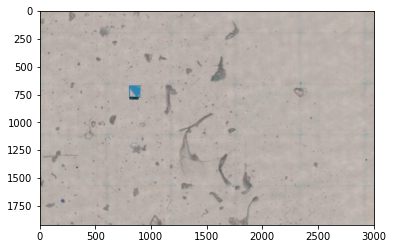

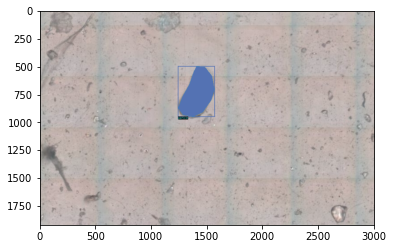

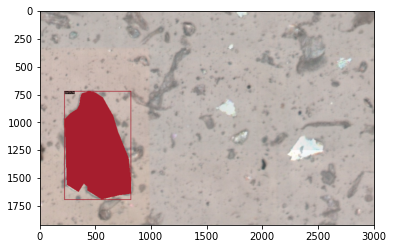

In [9]:
start_time = time.time()


##Split training and validation labels
if NUM_SAMPLE_LABELS !=0:
    val_sample = int(VALIDATION_RATIO*NUM_SAMPLE_LABELS)
    val_labels = random.sample(labels, val_sample)
    train_labels = random.sample(labels, NUM_SAMPLE_LABELS)
else:
    split = int(VALIDATION_RATIO*len(labels))
    val_labels = labels[:split]
    train_labels = labels[split:]

## Check and create folders for downloading data from Labelbox
train = 'train'
val = 'val'
inference = 'inference'
masks = 'masks'
tmp = 'tmp'

if not os.path.exists(DATA_LOCATION):
    os.makedirs(DATA_LOCATION)

if not os.path.exists(DATA_LOCATION+train):
    os.makedirs(DATA_LOCATION+train)
    
if not os.path.exists(DATA_LOCATION+val):
    os.makedirs(DATA_LOCATION+val)
    
if not os.path.exists(DATA_LOCATION+inference):
    os.makedirs(DATA_LOCATION+inference)
    
if not os.path.exists(DATA_LOCATION+masks):
    os.makedirs(DATA_LOCATION+masks)
    
if not os.path.exists(DATA_LOCATION+tmp):
    os.makedirs(DATA_LOCATION+tmp)
    
##Download training and validation labels in parallel
train_urls = []
for label in train_labels:
    train_urls.append((DATA_LOCATION+'train/' + label['External ID'], label['Labeled Data']))

val_urls = []
for label in val_labels:
    val_urls.append((DATA_LOCATION+'val/' + label['External ID'], label['Labeled Data']))


if(DOWNLOAD_IMAGES==True):
    print('Downloading training and validation data... \n')
    
    results_train = ThreadPool(NUM_CPU_THREADS).imap_unordered(download_files, train_urls)
    results_val = ThreadPool(NUM_CPU_THREADS).imap_unordered(download_files, val_urls)
    
    for item in results_train:
        pass
    for item in results_val:
        pass
    
    print('Finished downloading training and validation data... \n')
    

### Begin FB Detectron code. 

#Load dataset into Detectron2
try:
    DatasetCatalog.register(DETECTRON_DATASET_TRAINING_NAME, lambda: load_detectron2_dataset(train_labels, ontology, thing_classes, DATA_LOCATION+'train/' ))
    DatasetCatalog.register(DETECTRON_DATASET_VALIDATION_NAME, lambda: load_detectron2_dataset(val_labels, ontology, thing_classes, DATA_LOCATION+'val/' ))
    MetadataCatalog.get(DETECTRON_DATASET_TRAINING_NAME).thing_classes=thing_classes
    MetadataCatalog.get(DETECTRON_DATASET_VALIDATION_NAME).thing_classes=thing_classes
except Exception as e:
    print(e)
    
if MODE == 'object-detection':
    model = 'COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml'
    
if MODE == 'segmentation-rle':
    model = 'COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml'


##Load data and metadata for visualization and inference
dataset_dicts = DatasetCatalog.get(DETECTRON_DATASET_TRAINING_NAME)
dataset_dicts_val = DatasetCatalog.get(DETECTRON_DATASET_VALIDATION_NAME)
metadata = MetadataCatalog.get(DETECTRON_DATASET_TRAINING_NAME)

##check if the training data is loaded correctly
if HEADLESS_MODE==False:
    for d in random.sample(dataset_dicts, 3):
        img = cv2.imread(d["file_name"])
        visualizer = Visualizer(img[:, :, ::-1], metadata=metadata, scale=4)
        vis = visualizer.draw_dataset_dict(d)
        
        ## For paperspace cloud notebooks. Cloud notebooks do not support cv2.imshow.
        plt.rcParams['figure.figsize'] = (6, 12)
        plt.imshow(vis.get_image()[:, :, ::-1])
        plt.show()

### Quick debug

In [10]:

def get_stuff():
    response = client.execute(
                    """
                    query{
                      modelAssistedLabelingPredictionImports{
                        project{
                          name
                        }
                        id
                        name
                        inputFileUrl
                        errorFileUrl
                        }
                    }
                    """,
                    {"project_id": PROJECT_ID})
    
    return response
ans = get_stuff()['modelAssistedLabelingPredictionImports']

for an in ans:
    print(an['errorFileUrl'])
    
    
ontology, thing_classes = get_ontology(PROJECT_ID)
print('Available classes: ', thing_classes)
print(ontology)

https://storage.googleapis.com/labelbox-imports-prod/output/9e298dac-d577-0d57-93c8-3561918257eb/errors.ndjson?Expires=1653545777&GoogleAccessId=prediction-import-prod%40labelbox-193903.iam.gserviceaccount.com&Signature=l6p%2B1qwT%2BHkbDc6sBp2WfrQIJpIfYS2OSCGsyqLft%2Fw993Z1BGKY25iM1C37mf%2BiWkmkih5fmcW5TmgtVMBg8GJdDisML54Jos1dxXuLxdMIwrmeWGE0EJKBN%2BJ6kjAT6KkVVzvcFZyUpeo0uiHNmTrJyMLJDdRTQCUzM5S3JHBYcdd82GGvzyevI6Z7D8JhdnHjAjInmdHHhIMHL3YkE43M%2BBKZEgkp7To6p7%2FpGo%2FHfK3eg%2BxAsAdw1varWH5%2BgSF9Afpgo8qcwWRZ1qbJL6XVoBR9xBSAXmo4oTZiYav2Bi9qxYpff67VHjzOVTv67E73lalk0ogp%2BnU22dXhEQ%3D%3D
https://storage.googleapis.com/labelbox-imports-prod/output/9e5c0422-9175-0464-b983-1ceaf79a7dfd/errors.ndjson?Expires=1653545777&GoogleAccessId=prediction-import-prod%40labelbox-193903.iam.gserviceaccount.com&Signature=fYk06cD5gLf4j8ZXfTDqBObLEXXmfituOPOl%2BPpSVyyJaWlgLc%2FsFvE1F%2FHs%2F%2BPpikV24VkCYcgT8%2Fk9Caxw9ANu3CuIjAmm5A8Y57TpFVEHF%2BKppJaCm5EbQqoU9DVCdz7YnexxbZw9mGH%2Fm1xT1%2BGoiisYoMtlY176ksaACcV

# Train Detectron2 Model

In [11]:
## Train the model. Change the parameters as per your needs. 
    
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file(model))
cfg.DATASETS.TRAIN = (DETECTRON_DATASET_TRAINING_NAME,)
cfg.DATASETS.TEST = (DETECTRON_DATASET_VALIDATION_NAME,)   
cfg.TEST.EVAL_PERIOD = 150
cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(model)
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.00125
cfg.SOLVER.MAX_ITER = 600
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256   
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(thing_classes)

if MODE=='segmentation-rle':
    cfg.INPUT.MASK_FORMAT='bitmask'

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = CocoTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[05/25 08:16:21 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Num labels processing: 58


[================================================================================================================================] 100%


[05/25 08:16:40 d2.data.build]: Removed 0 images with no usable annotations. 58 images left.
[05/25 08:16:40 d2.data.build]: Distribution of instances among all 3 categories:
|  category  | #instances   |   category   | #instances   |  category  | #instances   |
|:----------:|:-------------|:------------:|:-------------|:----------:|:-------------|
|  particle  | 3341         | particle_seg | 1            |  particle  | 0            |
|            |              |              |              |            |              |
|   total    | 3342         |              |              |            |              |
[05/25 08:16:40 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[05/25 08:16:40 d2.data.build]: Using training sampler TrainingSampler
[05/25 08:16:40 d2.data.common]: Serializing 58 elements to byte tensors and concatenating them all ..

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (12, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (12,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (3, 256, 1, 1) 

[05/25 08:16:40 d2.engine.train_loop]: Starting training from iteration 0


/home/thibault.schowing/miniconda3/envs/labelbox/lib/python3.8/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[05/25 08:17:00 d2.utils.events]:  eta: 0:09:14  iter: 19  total_loss: 2.169  loss_cls: 1.324  loss_box_reg: 0.1411  loss_mask: 0.6904  loss_rpn_cls: 0.02957  loss_rpn_loc: 0.004384  time: 0.9493  data_time: 0.0801  lr: 4.0794e-05  max_mem: 5404M
[05/25 08:17:20 d2.utils.events]:  eta: 0:09:02  iter: 39  total_loss: 1.401  loss_cls: 0.6499  loss_box_reg: 0.1409  loss_mask: 0.5826  loss_rpn_cls: 0.02756  loss_rpn_loc: 0.006226  time: 0.9619  data_time: 0.0364  lr: 8.2419e-05  max_mem: 5404M
[05/25 08:17:39 d2.utils.events]:  eta: 0:08:42  iter: 59  total_loss: 1.084  loss_cls: 0.3959  loss_box_reg: 0.1373  loss_mask: 0.4599  loss_rpn_cls: 0.01576  loss_rpn_loc: 0.004158  time: 0.9642  data_time: 0.0376  lr: 0.00012404  max_mem: 5421M
[05/25 08:17:58 d2.utils.events]:  eta: 0:08:21  iter: 79  total_loss: 0.9139  loss_cls: 0.3292  loss_box_reg: 0.1761  loss_mask: 0.3877  loss_rpn_cls: 0.01999  loss_rpn_loc: 0.004749  time: 0.9612  data_time: 0.0327  lr: 0.00016567  max_mem: 5421M
[05/25 0

[================================================================================================================================] 100%


[05/25 08:19:15 d2.data.build]: Distribution of instances among all 3 categories:
|  category  | #instances   |   category   | #instances   |  category  | #instances   |
|:----------:|:-------------|:------------:|:-------------|:----------:|:-------------|
|  particle  | 951          | particle_seg | 0            |  particle  | 0            |
|            |              |              |              |            |              |
|   total    | 951          |              |              |            |              |
[05/25 08:19:15 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[05/25 08:19:15 d2.data.common]: Serializing 14 elements to byte tensors and concatenating them all ...
[05/25 08:19:15 d2.data.common]: Serialized dataset takes 0.29 MiB
WARNING [05/25 08:19:15 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. P

[05/25 08:19:23 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[05/25 08:19:23 d2.data.datasets.coco]: Conversion finished, #images: 14, #annotations: 951
[05/25 08:19:23 d2.data.datasets.coco]: Caching COCO format annotations at 'coco_eval/prelabeling-val_coco_format.json' ...
[05/25 08:19:23 d2.evaluation.evaluator]: Start inference on 14 batches


[05/25 08:19:25 d2.evaluation.evaluator]: Inference done 11/14. Dataloading: 0.0008 s/iter. Inference: 0.1167 s/iter. Eval: 0.0471 s/iter. Total: 0.1646 s/iter. ETA=0:00:00
[05/25 08:19:26 d2.evaluation.evaluator]: Total inference time: 0:00:01.463805 (0.162645 s / iter per device, on 1 devices)
[05/25 08:19:26 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:01 (0.114863 s / iter per device, on 1 devices)
[05/25 08:19:26 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[05/25 08:19:26 d2.evaluation.coco_evaluation]: Saving results to coco_eval/coco_instances_results.json
[05/25 08:19:26 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
[05/25 08:19:26 d2.evaluation.fast_eval_api]: Evaluate annotation type *bbox*
[05/25 08:19:26 d2.evaluation.fast_eval_api]: COCOeval_opt.evaluate() finished in 0.02 seconds.
[05/25 08:19:26 d2.evaluation

[05/25 08:21:59 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[05/25 08:21:59 d2.data.common]: Serializing 14 elements to byte tensors and concatenating them all ...
[05/25 08:21:59 d2.data.common]: Serialized dataset takes 0.29 MiB
WARNING [05/25 08:21:59 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[05/25 08:21:59 d2.evaluation.evaluator]: Start inference on 14 batches


[05/25 08:22:00 d2.evaluation.evaluator]: Inference done 11/14. Dataloading: 0.0007 s/iter. Inference: 0.0940 s/iter. Eval: 0.0115 s/iter. Total: 0.1063 s/iter. ETA=0:00:00
[05/25 08:22:01 d2.evaluation.evaluator]: Total inference time: 0:00:01.005802 (0.111756 s / iter per device, on 1 devices)
[05/25 08:22:01 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:00 (0.093584 s / iter per device, on 1 devices)
[05/25 08:22:01 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[05/25 08:22:01 d2.evaluation.coco_evaluation]: Saving results to coco_eval/coco_instances_results.json
[05/25 08:22:01 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
[05/25 08:22:01 d2.evaluation.fast_eval_api]: Evaluate annotation type *bbox*
[05/25 08:22:01 d2.evaluation.fast_eval_api]: COCOeval_opt.evaluate() finished in 0.01 seconds.
[05/25 08:22:01 d2.evaluation

[05/25 08:24:37 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[05/25 08:24:37 d2.data.common]: Serializing 14 elements to byte tensors and concatenating them all ...
[05/25 08:24:37 d2.data.common]: Serialized dataset takes 0.29 MiB
WARNING [05/25 08:24:37 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[05/25 08:24:37 d2.evaluation.evaluator]: Start inference on 14 batches


[05/25 08:24:38 d2.evaluation.evaluator]: Inference done 11/14. Dataloading: 0.0007 s/iter. Inference: 0.0891 s/iter. Eval: 0.0031 s/iter. Total: 0.0929 s/iter. ETA=0:00:00
[05/25 08:24:39 d2.evaluation.evaluator]: Total inference time: 0:00:00.898912 (0.099879 s / iter per device, on 1 devices)
[05/25 08:24:39 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:00 (0.089284 s / iter per device, on 1 devices)
[05/25 08:24:39 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[05/25 08:24:39 d2.evaluation.coco_evaluation]: Saving results to coco_eval/coco_instances_results.json
[05/25 08:24:39 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
[05/25 08:24:39 d2.evaluation.fast_eval_api]: Evaluate annotation type *bbox*
[05/25 08:24:39 d2.evaluation.fast_eval_api]: COCOeval_opt.evaluate() finished in 0.01 seconds.
[05/25 08:24:39 d2.evaluation

[================================================================================================================================] 100%


[05/25 08:27:20 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[05/25 08:27:20 d2.data.common]: Serializing 14 elements to byte tensors and concatenating them all ...
[05/25 08:27:20 d2.data.common]: Serialized dataset takes 0.29 MiB
WARNING [05/25 08:27:20 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[05/25 08:27:20 d2.evaluation.evaluator]: Start inference on 14 batches
[05/25 08:27:22 d2.evaluation.evaluator]: Inference done 11/14. Dataloading: 0.0007 s/iter. Inference: 0.1006 s/iter. Eval: 0.0016 s/iter. Total: 0.1028 s/iter. ETA=0:00:00
[05/25 08:27:22 d2.evaluation.evaluator]: Total inference time: 0:00:00.954235 (0.106026 s / iter per device, on 1 devices)
[05/25 08:27:22 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:00 (0.096387 s / iter per dev

# Create Detectron predictor with newly trained model

In [12]:
## Set newly trained model for inference. Make sure to set the appropriate threshold. 

cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = PRELABELING_THRESHOLD  # set threshold for this model
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")

#files.download('model_final.pth')

# Create predictor
predictor = DefaultPredictor(cfg)

[05/25 08:27:26 d2.checkpoint.c2_model_loading]: Following weights matched with model:
| Names in Model                                  | Names in Checkpoint                                                                                  | Shapes                                          |
|:------------------------------------------------|:-----------------------------------------------------------------------------------------------------|:------------------------------------------------|
| backbone.bottom_up.res2.0.conv1.*               | backbone.bottom_up.res2.0.conv1.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,1,1)             |
| backbone.bottom_up.res2.0.conv2.*               | backbone.bottom_up.res2.0.conv2.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,3,3)             |
| backbone.bottom_up.res2.0.conv3.*               | backbone.bottom_up.res2.0.conv3.{norm.bia

# Preview inferences

Schema_id: cl2771vun26q90z3j407dgam4
Schema_id: cl3l6zko80fo208bjfrvy122n
Schema_id: cl2771vun26q90z3j407dgam4
Schema_id: cl3l6zko80fo208bjfrvy122n


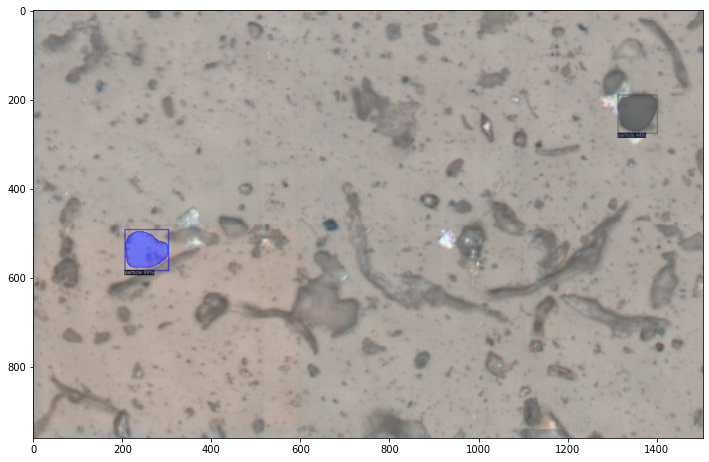

Schema_id: cl2771vun26q90z3j407dgam4
Schema_id: cl3l6zko80fo208bjfrvy122n


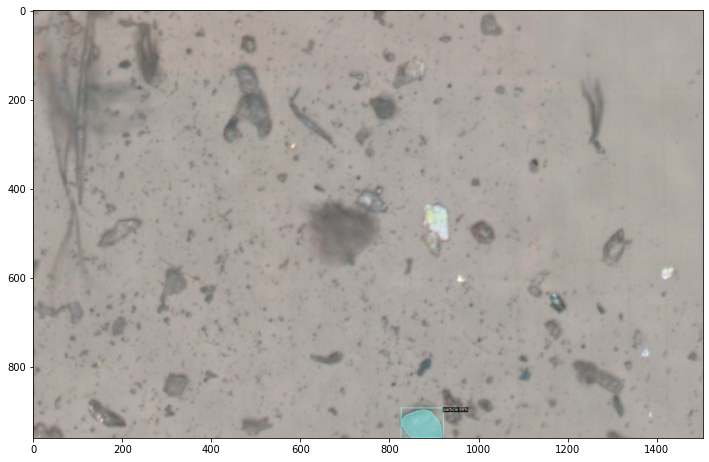

Schema_id: cl2771vun26q90z3j407dgam4
Schema_id: cl3l6zko80fo208bjfrvy122n
Schema_id: cl2771vun26q90z3j407dgam4
Schema_id: cl3l6zko80fo208bjfrvy122n


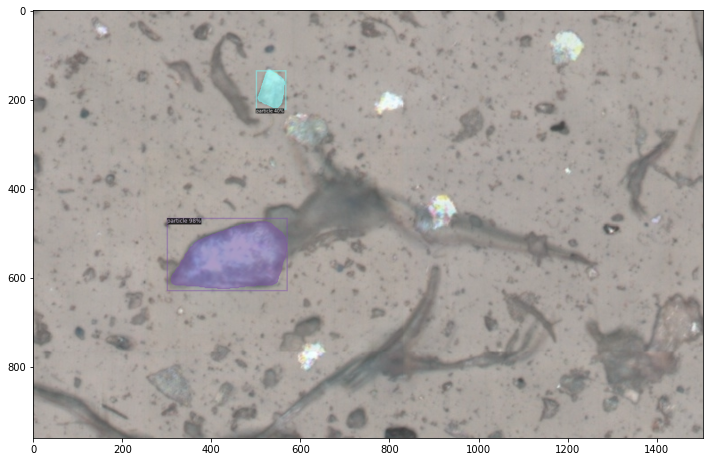

In [13]:
# Let's perform inferencing on random samples and preview the predictions before proceeding.
if HEADLESS_MODE==False:
    for d in random.sample(dataset_dicts, 3):    
            im = cv2.imread(d["file_name"])
            outputs = predictor(im)
            categories = outputs["instances"].to("cpu").pred_classes.numpy()
            predicted_boxes = outputs["instances"].to("cpu").pred_boxes
            
            if MODE=='segmentation-rle':
                pred_masks = outputs["instances"].to("cpu").pred_masks.numpy()

            if len(categories) != 0:
                for i in range(len(categories)):
                    classname = thing_classes[categories[i]]
                    for item in ontology:
                        if classname==item['name']:
                            schema_id = item['featureSchemaId']
                            print(f"Schema_id: {schema_id}")

            v = Visualizer(im[:, :, ::-1],
                        metadata=metadata, 
                        scale=2, 
            )
            v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
            
            ## For paperspace cloud notebooks. Cloud notebooks do not support cv2.imshow.
            plt.rcParams['figure.figsize'] = (12, 24)
            plt.imshow(v.get_image()[:, :, ::-1])
            plt.show()

# Delete existing model assisted labels from the Labelbox project

In [14]:
#Delete all existing bulk import requests from the Project. This will delete predictions from queued datarows.

all_import_requests = get_current_import_requests()

for task in all_import_requests:
    response = delete_import_request(task['id'])
    print(response)

{'deleteBulkImportRequest': {'id': '9e5c0422-9175-0464-b983-1ceaf79a7dfd', 'name': 'pre-labeling-05-20-2022-11-51-21'}}


# Compute unlabeled datarows

In [15]:
## Get datarows that needs to be pre-labeled. We are performing a subtraction (all datarows in project - labeled datarows)
datarow_ids_with_labels = []

for label in labels:
    datarow_ids_with_labels.append(label['DataRow ID'])
    
all_datarow_ids = []
all_datarows = []

for dataset_id in DATASETS:
    dataset = client.get_dataset(dataset_id)
    for data_row in dataset.data_rows():
        all_datarow_ids.append(data_row.uid)
        all_datarows.append(data_row)

datarow_ids_queued = diff_lists(all_datarow_ids, datarow_ids_with_labels)

print('Number of datarows to be pre-labeled: ', len(datarow_ids_queued))


Number of datarows to be pre-labeled:  3


# Download unlabeled data for inferencing

In [16]:
## Download queued datarows that needs to be pre-labeled

data_row_queued = []
data_row_queued_urls = []

for datarow in all_datarows:
    for datarow_id in datarow_ids_queued:
        if datarow.uid == datarow_id:
            data_row_queued.append(datarow)
            extension = os.path.splitext(datarow.external_id)[1]
            filename = datarow.uid + extension
            data_row_queued_urls.append((DATA_LOCATION+'inference/' + filename, datarow.row_data))

print('Downloading queued data for inferencing...\n')
filepath_inference = ThreadPool(NUM_CPU_THREADS).imap_unordered(download_files, data_row_queued_urls)
print('Success...\n')


Success...



# Perform inferencing

In [17]:
## Inferencing on queued datarows and create labelbox annotation import file 
#(https://labelbox.com/docs/automation/model-assisted-labeling)

predictions = []
counter = 1

print("Inferencing...\n")
time.sleep(1)
bar = progressbar.ProgressBar(maxval=len(data_row_queued), \
    widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
bar.start()
print("Start loop...\n")
for datarow in data_row_queued:
    extension = os.path.splitext(datarow.external_id)[1]
    filename = DATA_LOCATION+'inference/' + datarow.uid + extension
    im = cv2.imread(filename)
    
    ##Predict using FB Detectron2 predictor
    outputs = predictor(im)
    
    categories = outputs["instances"].to("cpu").pred_classes.numpy()
    predicted_boxes = outputs["instances"].to("cpu").pred_boxes

    if len(categories) != 0:
        for i in range(len(categories)):
            
            classname = thing_classes[categories[i]]
            
            for item in ontology:
                if classname==item['name']:
                    schema_id = item['featureSchemaId']
            
            if MODE=='segmentation-rle':
                print("Mode: Segmentation-rle\n")
                pred_mask = outputs["instances"][i].to("cpu").pred_masks.numpy()
                cloud_mask = mask_to_cloud(im,pred_mask, datarow.uid)
                mask = {'instanceURI': cloud_mask, "colorRGB": [255,255,255]}
                
                predictions.append({"uuid": str(uuid4()),'schemaId': schema_id, 'mask': mask, 'dataRow': { 'id': datarow.uid }})
                
            if MODE=='object-detection':
                bbox = predicted_boxes[i].tensor.numpy()[0]
                bbox_dimensions = {'left': int(bbox[0]), 'top': int(bbox[1]), 'width': int(bbox[2]-bbox[0]), 'height': int(bbox[3]-bbox[1])}
                predictions.append({"uuid": str(uuid4()),'schemaId': schema_id, 'bbox': bbox_dimensions, 'dataRow': { 'id': datarow.uid }})
            
    # print('\predicted '+ str(counter) + ' of ' + str(len(data_row_queued)))
    bar.update(counter)
    counter = counter + 1
          
bar.finish()
time.sleep(1)
print('Total annotations predicted: ', len(predictions))
print(predictions)

Inferencing...



Start loop...

Mode: Segmentation-rle



Mode: Segmentation-rle



[================================================================================================================================] 100%


Mode: Segmentation-rle

Total annotations predicted:  3
[{'uuid': 'a85c37bf-5c0a-4728-9665-fd4042a6807b', 'schemaId': 'cl3l6zko80fo208bjfrvy122n', 'mask': {'instanceURI': 'https://storage.googleapis.com/storage-test-1-imptox/7a2abc5a-b384-441e-8021-395f760fc629.png?Expires=1659508050&GoogleAccessId=imptox-service-account2rw%40imptox-data-storage.iam.gserviceaccount.com&Signature=Rho20iUb4XuUtZAzfLX7%2BABSvA9NDA7ktj4piasdTCjYQ6ECBe7xOaalLC%2FzcqARuIbC51taJDAfd2krOu1eJxiNpzI3ilkM8hUXDy9KcbGQpG25yWi2fuKsM%2FyjiYzkQbMF6tryBtX2FOc0B3g%2FSpituOF0QVtyiFMtzvYp1NfojsqK%2FX6jTMsxRuPC34JfJEuLJyY1GNHv7VLwBLvDp8rFIJLXxyRBoMLQ%2Bd09%2B3cNNB3641Ta%2BD6M5AYhfblf64MfNTS2zKwzCFxLZfIwZGRhyJANx4GCw1Ei322MFFx%2B4A9XzcXUxUl5lBbbtCQomiR9xC24z%2F6ueSe6yLz7kA%3D%3D', 'colorRGB': [255, 255, 255]}, 'dataRow': {'id': 'cl2aevtzw1sj70ztp92sk08rz'}}, {'uuid': 'd1b5242d-4dca-4f77-a7e5-e16e78dd89d3', 'schemaId': 'cl3l6zko80fo208bjfrvy122n', 'mask': {'instanceURI': 'https://storage.googleapis.com/storage-test-1-imptox/

# Upload model predictions to Labelbox

In [18]:
##Upload predicted annotations to Labelbox project
now = datetime.now() # current date and time
job_name = 'pre-labeling-' + str(now.strftime("%m-%d-%Y-%H-%M-%S"))

upload_job = project.upload_annotations( 
    name=job_name, 
    annotations=predictions)

print(upload_job)

upload_job.wait_until_done()

print("State", upload_job.state)

print("--- Finished in %s seconds ---" % (time.time() - start_time))


<BulkImportRequest {'created_at': datetime.datetime(2022, 5, 25, 6, 27, 32, 391000, tzinfo=datetime.timezone.utc), 'error_file_url': None, 'input_file_url': 'https://storage.googleapis.com/labelbox-predictions-import-prod/uploaded_predictions/ckx5rns9a7ukj0zawbh2645im/38bb5a9a-f9ed-991a-7063-4ae85f96d2c2-cl1xko1at42480zai2aheh2ip__pre-labeling-05-25-2022-08-27-32.ndjson?GoogleAccessId=api-prod%40labelbox-193903.iam.gserviceaccount.com&Expires=1654064852&Signature=KphlTQjUetj8COC2xEEHzrEVoWrNWDUgoCMsS8aospJJh9ftLO%2Fc6%2FW2HxZlU0KwYob8F0cObhePmL69QHn%2F4ut7IVGh90%2BhCqStCfHeCEN%2B2cnuK67MPTgDIujBWL7oJBMYG05MQnVLEnm%2B17X8dKx384NO3MVtRaAnp9FpMJyuSPI5nfQjdbtoh4aKNOiMmP43hlBo27qT1R34acAVfV6w6gDa3hdrnDirQnIamK1N8e%2FAe7sqtgDWKrUTFo5F%2BgA004roA3Nrvj30ZTS9a0GE8Ute7%2BvnZEzaiEdpSzJkxGAxOz9BBJvTU%2FSBvzrxwtRFIwQBYuxLgLMmXAKD4g%3D%3D', 'name': 'pre-labeling-05-25-2022-08-27-32', 'state': <BulkImportRequestState.RUNNING: 'RUNNING'>, 'status_file_url': None, 'uid': '9e664f91-83ab-04d9-936b-e8e81f